## Create Custom Dataset for Dog 1 Files

In [1]:
import os
import numpy as np
from scipy.io import loadmat

Create annotation file by using label in filename. So if a file contains interictal, it is 0 and if it contains preictal it is 1. We ignore any files labelled test.

In [2]:
dog_one_files = sorted(os.listdir('data_copy/Dog_1/Dog_1'))
dog_one_ffiles = list(filter(lambda f: 'test' not in f, dog_one_files)) # ignore files labelled 'test'

In [3]:
def map_label(label):
    if label == 'interictal':
        return -1
    if label == 'preictal':
        return 1

annotations_dict = {f:map_label(f.split('.')[0].split('_')[2]) for f in dog_one_ffiles}

In [4]:
import csv

file = open('data_copy/Dog_1/annotations.csv', 'w')
writer = csv.writer(file)
for key, value in annotations_dict.items():
    writer.writerow([key, value])
file.close()

In [5]:
!ls data_copy/Dog_1

Dog_1  annotations.csv


In [6]:
!tail data_copy/Dog_1/annotations.csv

In [7]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [8]:
class EEGTrainDataset(Dataset):
    def __init__(self, annotations_file, segment_dir, transform=None, target_transform=None):
        self.segment_labels = pd.read_csv(annotations_file)
        self.segment_dir = segment_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.segment_labels)
    
    def __getitem__(self, idx):
        segment_path = os.path.join(self.segment_dir, self.segment_labels.iloc[idx, 0])
        mat = loadmat(segment_path)
        segment_name = list(mat.keys())[-1]
        segment = mat[segment_name]
        signal = segment['data'][0][0]
        fs = segment['sampling_frequency'][0][0][0][0]
        label = self.segment_labels.iloc[idx, 1]
        if self.transform:
            signal = self.transform(signal)
        if self.target_transform:
            label = self.target_transform(label)
        return signal, fs, label

In [9]:
class EEGTestDataset(Dataset):
    def _getfiles(self):
        files = sorted(os.listdir(self.segment_dir))
        ffiles = list(filter(lambda f: 'test' in f, files))
        return ffiles
    
    def __init__(self, segment_dir, transform=None):
        self.segment_dir = segment_dir
        self.transform = transform
    
    def __len__(self):
        return len(self._getfiles())
    
    def __getitem__(self, idx):
        files = self._getfiles()
        segment_path = os.path.join(self.segment_dir, files[idx])
        mat = loadmat(segment_path)
        segment_name = list(mat.keys())[-1]
        segment = mat[segment_name]
        signal = segment['data'][0][0]
        fs = segment['sampling_frequency'][0][0][0][0]
        channels = segment['channels'][0][0][0]
        if self.transform:
            signal = self.transform(signal)
        return signal, fs

## Data preparation with DataLoaders

In [10]:
training_data = EEGTrainDataset(
    annotations_file='data_copy/Dog_1/annotations.csv',
    segment_dir='data_copy/Dog_1/Dog_1'    
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [11]:
test_data = EEGTestDataset(
    segment_dir='data_copy/Dog_1/Dog_1'
)

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through DataLoader

In [12]:
train_features, train_fss, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Sampling frequency batch shape: {train_fss.size()}")
print(f"Labels batch shape: {train_labels.size()}")

signal = train_features[0].squeeze()
fs = train_fss[0]
label = train_labels[0]

Feature batch shape: torch.Size([64, 16, 239766])
Sampling frequency batch shape: torch.Size([64])
Labels batch shape: torch.Size([64])


In [13]:
print(fs)
print(signal.shape)
print(signal)
print(label)

tensor(399.6098, dtype=torch.float64)
torch.Size([16, 239766])
tensor([[ 12,  29,  29,  ...,   3, -10,  -8],
        [ 10,  22,  26,  ..., -42, -53, -48],
        [-11, -14, -12,  ...,   5,   9,   3],
        ...,
        [ -6,   5,  -2,  ...,   8,   2,   4],
        [  3,   3,   6,  ...,  20,  24,  19],
        [-12, -15, -18,  ...,  19,  22,  24]], dtype=torch.int16)
tensor(-1)


In [14]:
test_features, test_fss = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Sampling frequency batch shape: {test_fss.size()}")
signal = test_features[0].squeeze()
fs = test_fss[0]

Feature batch shape: torch.Size([64, 16, 239766])
Sampling frequency batch shape: torch.Size([64])


In [15]:
print(fs)
print(signal.shape)
print(signal)

tensor(399.6098, dtype=torch.float64)
torch.Size([16, 239766])
tensor([[ -2,   8,  15,  ...,  -1, -12, -11],
        [ 34,  17,  11,  ...,  10,  -9, -20],
        [ 17,   8,   5,  ..., -16, -27, -26],
        ...,
        [ -4,   2,  -2,  ...,  -2,  -1,  -1],
        [-22, -16,  -5,  ...,  -6,   7,  23],
        [-31, -30, -20,  ...,   4,   5,  22]], dtype=torch.int16)


## Feature Extraction

In [71]:
import torch
from scipy.fft import fft, rfft, ifft, fftfreq, rfftfreq
import matplotlib.pyplot as plt

In [77]:
train_features, train_fss, train_labels = next(iter(train_dataloader))
signal = train_features[0].squeeze().numpy()
fs = train_fss[0].numpy()
label = train_labels[0].numpy()
print(fs)
print(signal.shape)
print(signal)
print(label)

399.609756097561
(16, 239766)
[[ 30  24  14 ... -19 -34 -48]
 [ -1  14  15 ...  18  13   9]
 [ -5  -4 -10 ...  16  21  23]
 ...
 [-23 -40 -34 ...   7  -8 -11]
 [-21 -22 -16 ...   1  -3  -4]
 [-33 -38 -34 ...  16   9  23]]
-1


## Visual inspection

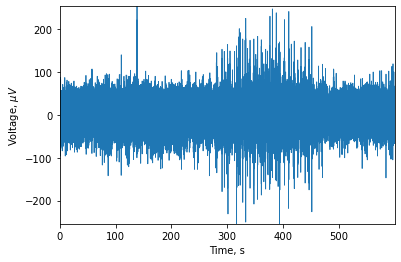

In [95]:
N = signal.shape[1]
t = np.arange(0, N) / fs
EEG = signal[0,:]
plt.plot(t, EEG, linewidth=0.8) # plotting channel 1
plt.xlabel('Time, s')
plt.ylabel('Voltage, $\mu V$')
plt.autoscale(tight=True)
plt.show()

In [87]:
EEG.shape

(239766,)

Text(0, 0.5, 'Voltage, $\\mu V$')

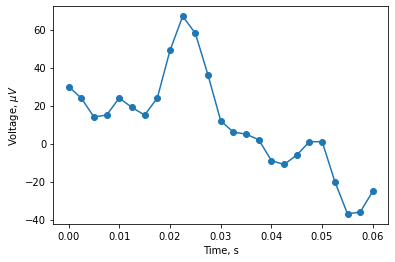

In [91]:
plt.plot(t[:25], EEG[:25], 'o-')
plt.xlabel('Time, s')
plt.ylabel('Voltage, $\mu V$')

In [92]:
x = EEG           # Relabel the data variable
dt = t[1] - t[0]  # Define the sampling interval
N = x.shape[0]    # Define the total number of data points
T = N * dt        # Define the total duration of the data

In [93]:
mn = x.mean()  # Compute the mean of the data
vr = x.var()   # Compute the variance of the data
sd = x.std()   # Compute the standard deviation of the data

print('mn = ' + str(mn))
print('vr = ' + str(vr))
print('sd = ' + str(sd))

mn = -0.037557451848885995
vr = 788.3385917734212
sd = 28.077367963778606


In [18]:
x = torch.tensor([1,2,3,4,5,6,7,8])

# partition into non-overlapping 1 min windows
step = 2
window_size = 2
x.unfold(-1, window_size, step)

tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])

$f = \frac{1}{T}$

where, $f$ - frequency (Hz), $T$ - time period (s)

Thus, $t = \frac{1}{f} = \frac{1}{400} = 0.0025$ seconds per sample.

In 1 min, there are 60 seconds. If every sample takes 0.0025 seconds, how many samples in 60 seconds?

$\frac{60}{0.0025} = 24000$ samples

In [19]:
60/(1/400)

24000.0

As each recording is 10 mins long, there should be 10 lots of 24000 samples:

In [20]:
239766/24000

9.99025

In [21]:
# compute number of samples in 1-min
window_size = int(torch.round((60 / (1/fs))).item())
step_size = window_size # non-overlapping

# select a channel
ch_signal = signal[0,:]

# non-overlapping 1 minute sliding windows
one_min_blocks = ch_signal.unfold(-1, window_size, step)

In [66]:
# consider the first block
b1 = one_min_blocks[0].numpy()

# apply Real Fast Fourier Transform (R-FFT)
fourier = rfft(b1)
n = b1.size
timestep = (1/fs).item()

# get Real Discrete Fourier Transform (R-DFT) sample frequencies
freq = rfftfreq(n, d=timestep)
freq

array([0.00000000e+00, 1.66663785e-02, 3.33327569e-02, ...,
       1.99763212e+02, 1.99779878e+02, 1.99796545e+02])

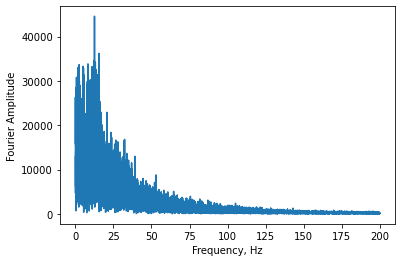

In [70]:
plt.plot(freq, np.abs(fourier))
plt.xlabel('Frequency, Hz')
plt.ylabel('Fourier Amplitude')
plt.show()